<a href="https://colab.research.google.com/github/mattiabombieri/NeuralNetwork_Tesi_MB/blob/main/NetworkFittingDifferentNetworksUnivariate_ITM_MB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import math as mt
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

2.18.0
Mounted at /content/drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

StartingValues = np.load('/content/drive/My Drive/startingvaluesUniVariateITM.npy')
print(StartingValues)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[[ 0.36999885  0.06088184 -0.27843507 ...  0.05552605  0.27597337
   0.46055534]
 [ 0.41627211 -0.32638021  0.30962175 ...  0.10310086 -0.32621497
  -0.0346609 ]
 [ 0.45123417  0.28628765 -0.34419823 ...  0.17506217 -0.22866537
   0.30101809]
 ...
 [ 0.2657931  -0.06870523 -0.13819409 ...  0.24828656  0.03992342
   0.29094948]
 [-0.12807186  0.42792914  0.27162283 ... -0.05987048 -0.47285047
  -0.04101031]
 [ 0.38745462  0.36525259 -0.33679535 ... -0.19790725 -0.3148698
  -0.31740994]]


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Y = np.load('/content/drive/My Drive/outputsUniVariateITM.npy')
print(Y)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[0.97322275 0.33960061 0.42053087 ... 0.57118548 0.64038337 1.04606551]


In [4]:
import os
os.getcwd()

from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Lambda
from tensorflow.keras.losses import MeanSquaredError
#from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import initializers
from tensorflow.keras.layers import Input, Add
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K

import time

In [5]:
# Custom activation function
vector_z = [0.25, 0.25, 0.25, 0.25, 0, 0, 0] # This is the vector z we need to choose in Example 2.12
vector_psi = [0.25, 0.25, 0.25, 0.25, 0, 0, 0] # This is the vector that encodes the function psi in Example 2.12
psi=tf.constant(vector_psi)
z = tf.constant(vector_z)

def custom_fct(x):
    psi_mat = tf.expand_dims(psi, axis = 0)
    psi_mat_t = tf.transpose(psi_mat)
    #psi_mat_batch=tf.broadcast_to(psi_mat, [3,1,3])
    tmp = tf.matmul(x, psi_mat_t)
    tmp2 = K.maximum(tf.zeros_like(tmp), 1 - K.exp(-tmp))
    tmp3 = tmp2 * z
    return tmp3 # tf.math.scalar_mul(tmp4, z)

In [6]:
approxDim = 7 # This is the approximation dimension, the number of basis functions we consider

models = []
for k in range(1, 31, 1):
    inputs =  tf.keras.Input(shape=(7, ))
    nodes = []
    # After each node is a lambda layer that implements our activation function
    lambda_layers = []
    # Final linear forms that are applied
    linear_form_layers=[]
    for j in range(k):
        node = Dense(approxDim, activation = None, trainable = True,
                      kernel_initializer = initializers.RandomNormal(0, 1), # kernel_initializer='random_normal',
                      bias_initializer = 'random_normal',
                      name = str('node') + str(j))
        lamb = Lambda(custom_fct, name = str('activation') + str(j))
        lin = Dense(1, activation = None, trainable = True,
                      kernel_initializer = initializers.RandomNormal(0, 1), # kernel_initializer='random_normal',
                      use_bias = False,
                      name = str('linearForm') + str(j))
        nodes = nodes + [node]
        lambda_layers = lambda_layers + [lamb]
        linear_form_layers = linear_form_layers + [lin]


    all_linear_form_outputs=[]
    for j in range(k):
        output_linearmap = nodes[j](inputs)
        output_activation = lambda_layers[j](output_linearmap)
        output_linear_form = linear_form_layers[j](output_activation)
        all_linear_form_outputs = all_linear_form_outputs + [output_linear_form]


    #print(all_linear_form_outputs)
    add_layer = Add()

    if k > 1:
        finalOutput = add_layer(all_linear_form_outputs)
    else:
        finalOutput = all_linear_form_outputs[0]
#print(finalOutput)

    model = Model(inputs = inputs, outputs = finalOutput)
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    models = models + [model]

In [7]:
# for k in range(0, len(models), 1):
#     tic = time.perf_counter()
#     models[k].fit(StartingValues, Y, epochs = 50, batch_size = 10000)
#     toc = time.perf_counter()
#     print(f"Calc time: {(toc - tic)/60.0:0.4f} minutes")

from tensorflow.keras.callbacks import EarlyStopping
import time

early_stopping = EarlyStopping(
    monitor = 'val_loss',  # Monitora la perdita sulla validazione
    patience = 3,          # Numero di epoche senza miglioramenti prima di fermarsi
    restore_best_weights = True  # Ripristina i pesi della migliore epoca
)

for k in range(len(models)):  # Non serve scrivere range(0, len(models), 1)
    tic = time.perf_counter()

    models[k].fit(
        StartingValues, Y,
        epochs = 50,
        batch_size = 10000,
        validation_split = 0.2,  # Usa il 20% dei dati per la validazione
        callbacks = [early_stopping]  # Attiva l'early stopping
    )

    toc = time.perf_counter()
    print(f"Calc time: {(toc - tic)/60.0:0.4f} minutes")

Epoch 1/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1747 - val_loss: 0.0912
Epoch 2/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0879 - val_loss: 0.0847
Epoch 3/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0845 - val_loss: 0.0845
Epoch 4/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0845 - val_loss: 0.0844
Epoch 5/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0844 - val_loss: 0.0843
Epoch 6/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0842 - val_loss: 0.0842
Epoch 7/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0840 - val_loss: 0.0841
Epoch 8/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0840 - val_loss: 0.0840
Epoch 9/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0839 - val_loss: 0.0839
Epoch 10/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0837 - val_loss: 0.0838
Epoch 11/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0836 - val_loss: 0.0837
Epoch 12/50
800/800 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

In [8]:
from google.colab import drive
drive.mount('/content/drive')

#MCpricesTestset=np.load('outputsMultiVariateTestset.npy')
#xvaluesTestset=np.load('startingvaluesMultiVariateTestset.npy')
startingValues = np.zeros([9600, 7])
MCprices = np.zeros([9600])
for k in range(0, 30, 1):
    tmpstring = "% s" % k
    filename1 = "/content/drive/My Drive/startingvaluesUniVariateTestset100000SimITM" + tmpstring + ".npy"
    filename2 = "/content/drive/My Drive/outputsUniVariateTestset100000SimITM" + tmpstring + ".npy"
    tmp1 = np.load(filename1)
    tmp2 = np.load(filename2)
    startingValues[k * 320 : (k+1) * 320] = tmp1
    MCprices[k * 320 : (k+1) * 320] = tmp2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[1.76320097e-03 1.15715596e-03 3.12538439e-04 1.03509497e-04
 1.24353595e-04 2.76381488e-05 4.56129346e-05 7.76304369e-05
 4.35139627e-05 2.52293776e-05 2.97087681e-05 7.71593914e-05
 1.04153019e-04 4.08559936e-05 6.97847281e-05 3.79289449e-05
 4.28280764e-05 9.97796596e-05 4.51312153e-05 3.37381025e-05
 3.16760124e-05 3.00761094e-05 4.75199013e-05 3.80621132e-05
 5.61783709e-05 3.30832154e-05 4.49883992e-05 3.71766364e-05
 5.74753431e-05 5.17681110e-05]


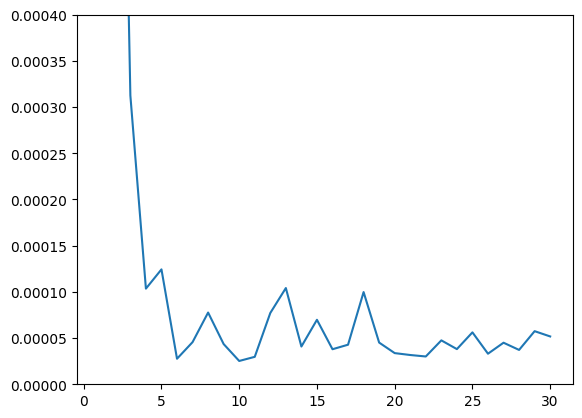

In [9]:
mctf = tf.reshape(tf.constant(MCprices), [MCprices.shape[0], 1])
mctf = tf.dtypes.cast(mctf, tf.float32)
mse = tf.keras.losses.MeanSquaredError()
mses = np.zeros(30)
for k in range(0, 30, 1):
    predictions = models[k](startingValues)
    mses[k] = mse(predictions, mctf).numpy()
print(mses)
xvalues = range(1, 31, 1)
plt.ylim([0., 0.0004])
plt.plot(xvalues,mses)
plt.show()

9
4.912666890959372e-05


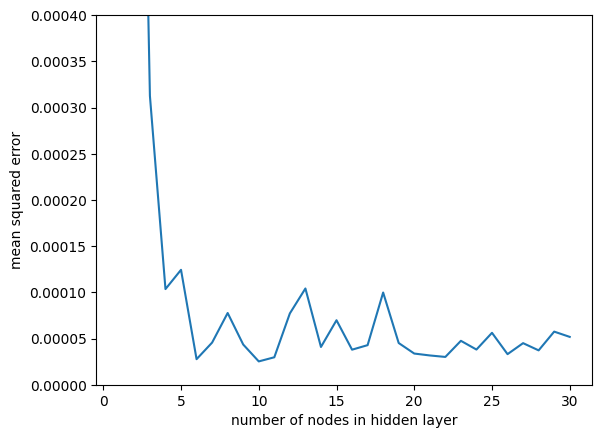

In [10]:
xvalues = range(1, 31, 1)
print(np.argmin(mses))
print(np.average(mses[9 : 29]))
fig = plt.figure()
ax = plt.axes()
plt.ylim([0., 0.0004])
ax.set(xlabel = 'number of nodes in hidden layer', ylabel = 'mean squared error',
       title='')
ax.plot(xvalues, mses)
plt.show()